In [5]:
import warnings
warnings.filterwarnings("ignore")

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [3]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [6]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [7]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [9]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [10]:
X2D_using_svd = X2D

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [12]:
X3D_inv = pca.inverse_transform(X2D)

In [13]:
np.allclose(X3D_inv, X)

False

In [14]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

In [15]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

In [16]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

In [17]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

In [18]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [19]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

In [20]:
from six.moves import urllib
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [21]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [22]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [23]:
d

154

In [24]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [25]:
pca.n_components_

154

In [26]:
np.sum(pca.explained_variance_ratio_)

0.950446303020019

In [27]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [28]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

Text(0.5,1,'Compressed')

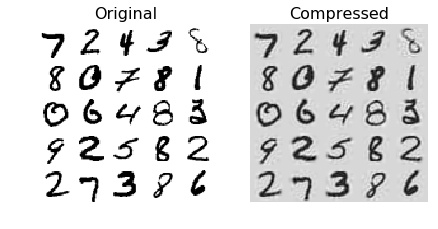

In [29]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)


In [30]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [2]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [3]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

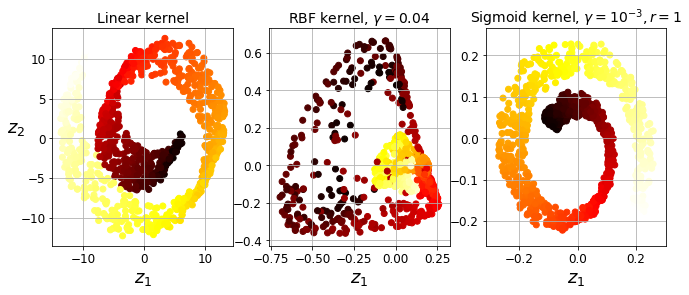

In [6]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression())
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='linear',
     kernel_params=None, max_iter=None, n_components=2, n_jobs=1,
     random_state=None, remove_zero_eig=False, tol=0)), ('log_reg', LogisticRegre...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kpca__gamma': array([0.03   , 0.03222, 0.03444, 0.03667, 0.03889, 0.04111, 0.04333,
       0.04556, 0.04778, 0.05   ]), 'kpca__kernel': ['rbf', 'sigmoid']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [8]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [9]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [10]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.78630879576614

In [11]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [12]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

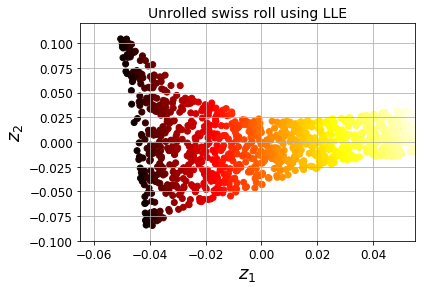

In [13]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

In [14]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [15]:
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

In [16]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(random_state=42)

In [17]:
import time

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

In [18]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 4.70s


In [19]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9455

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

In [21]:
rnd_clf2 = RandomForestClassifier(random_state=42)
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

In [22]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 9.81s


In [23]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.8908

In [24]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

In [25]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 101.50s


In [26]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9252

In [27]:
log_clf2 = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

In [28]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 23.44s


In [29]:
y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9198

In [30]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')

In [34]:
np.random.seed(42)

m = 5000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

In [35]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

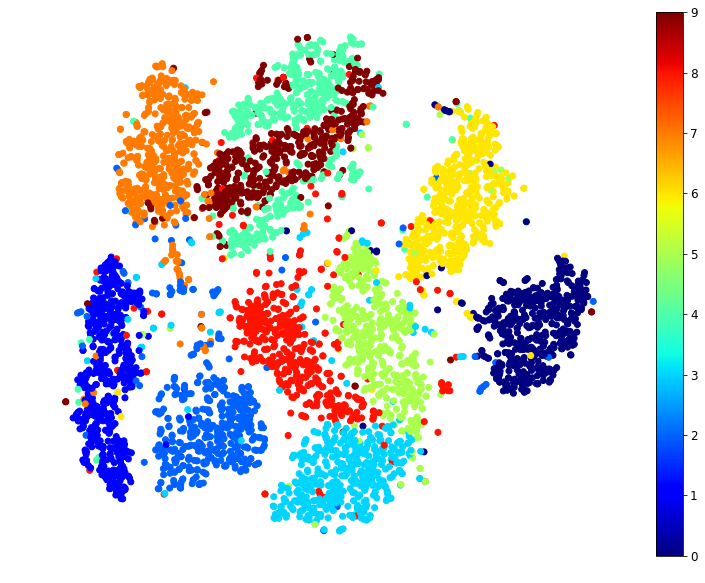

In [36]:
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

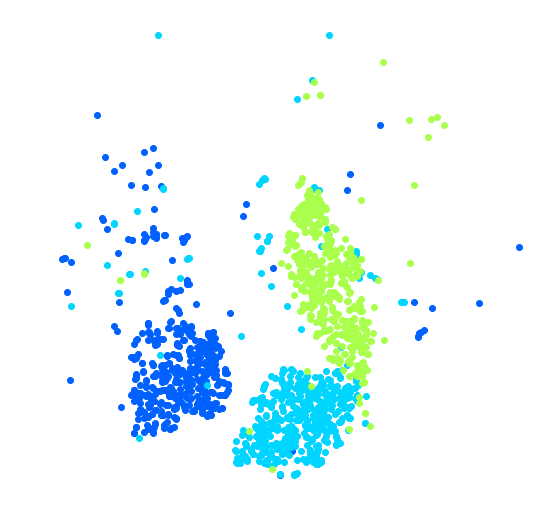

In [37]:
plt.figure(figsize=(9,9))
cmap = matplotlib.cm.get_cmap("jet")
for digit in (2, 3, 5):
    plt.scatter(X_reduced[y == digit, 0], X_reduced[y == digit, 1], c=cmap(digit / 9))
plt.axis('off')
plt.show()

In [38]:
idx = (y == 2) | (y == 3) | (y == 5) 
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

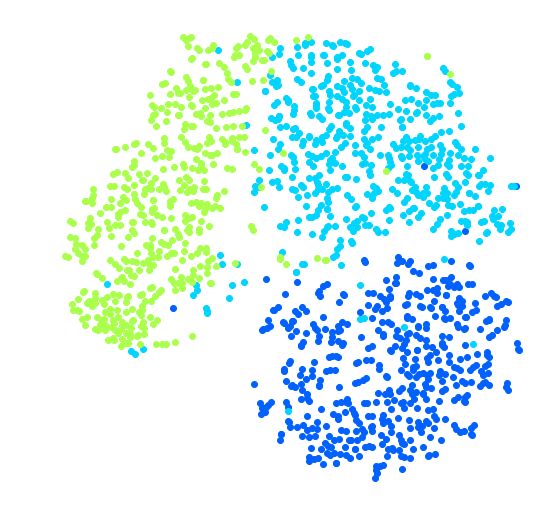

In [39]:
plt.figure(figsize=(9,9))
for digit in (2, 3, 5):
    plt.scatter(X_subset_reduced[y_subset == digit, 0], X_subset_reduced[y_subset == digit, 1], c=cmap(digit / 9))
plt.axis('off')
plt.show()

In [40]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = matplotlib.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=cmap(digit / 9))
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

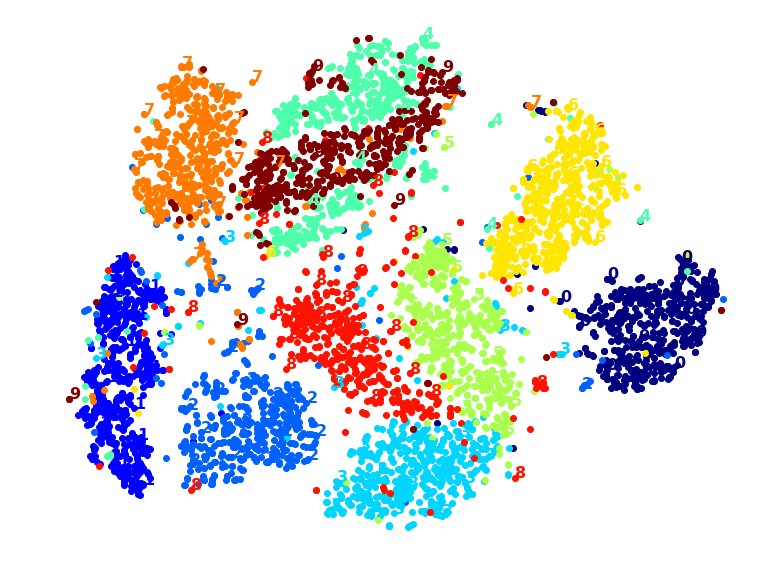

In [41]:
plot_digits(X_reduced, y)

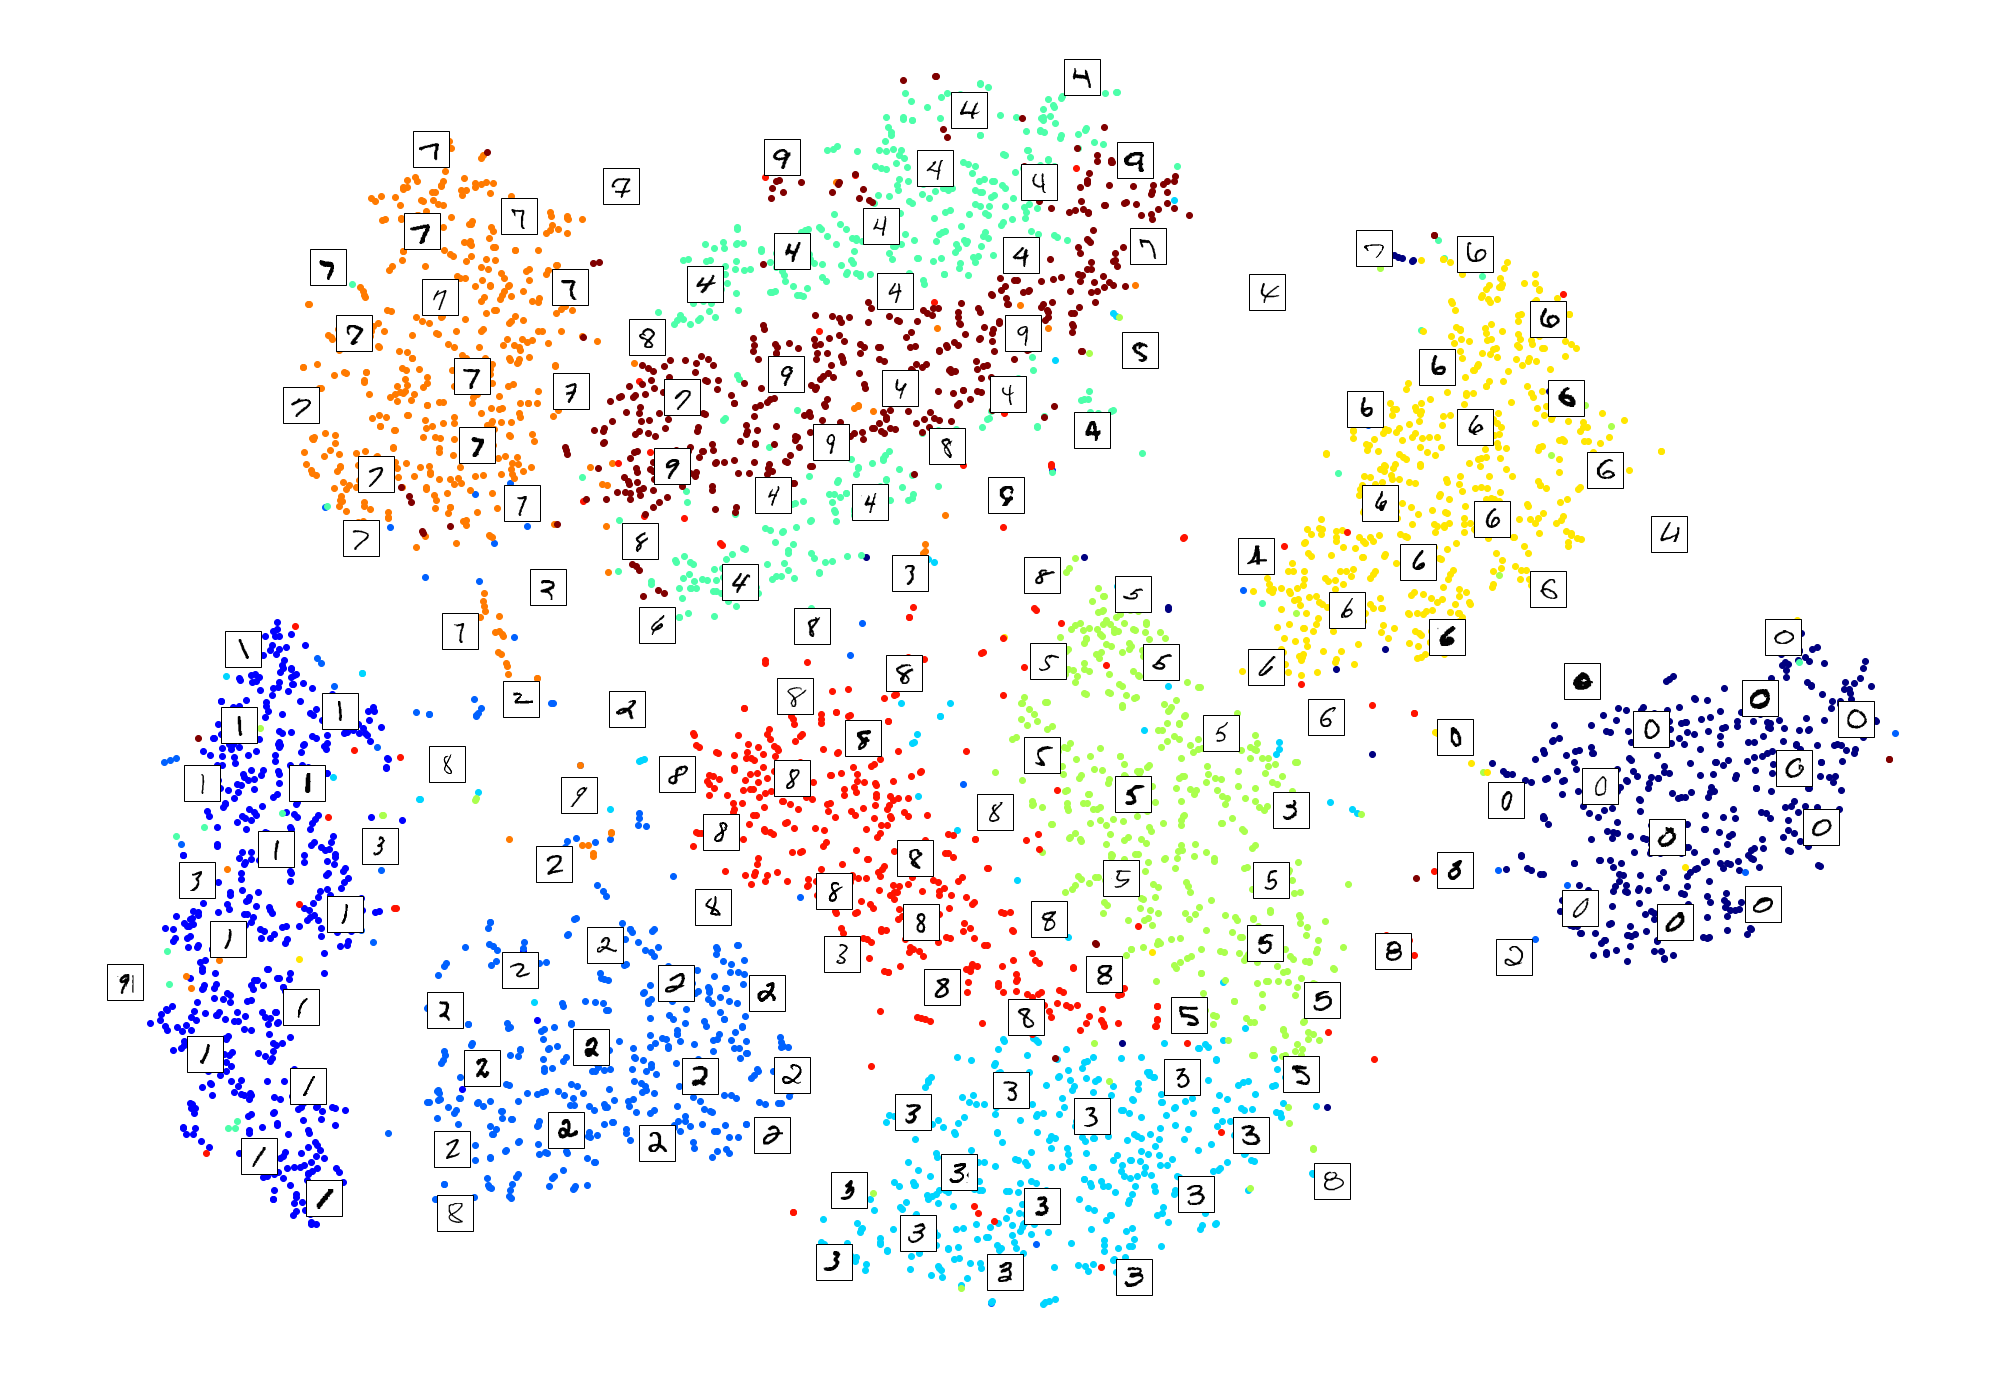

In [42]:
plot_digits(X_reduced, y, images=X, figsize=(35, 25))

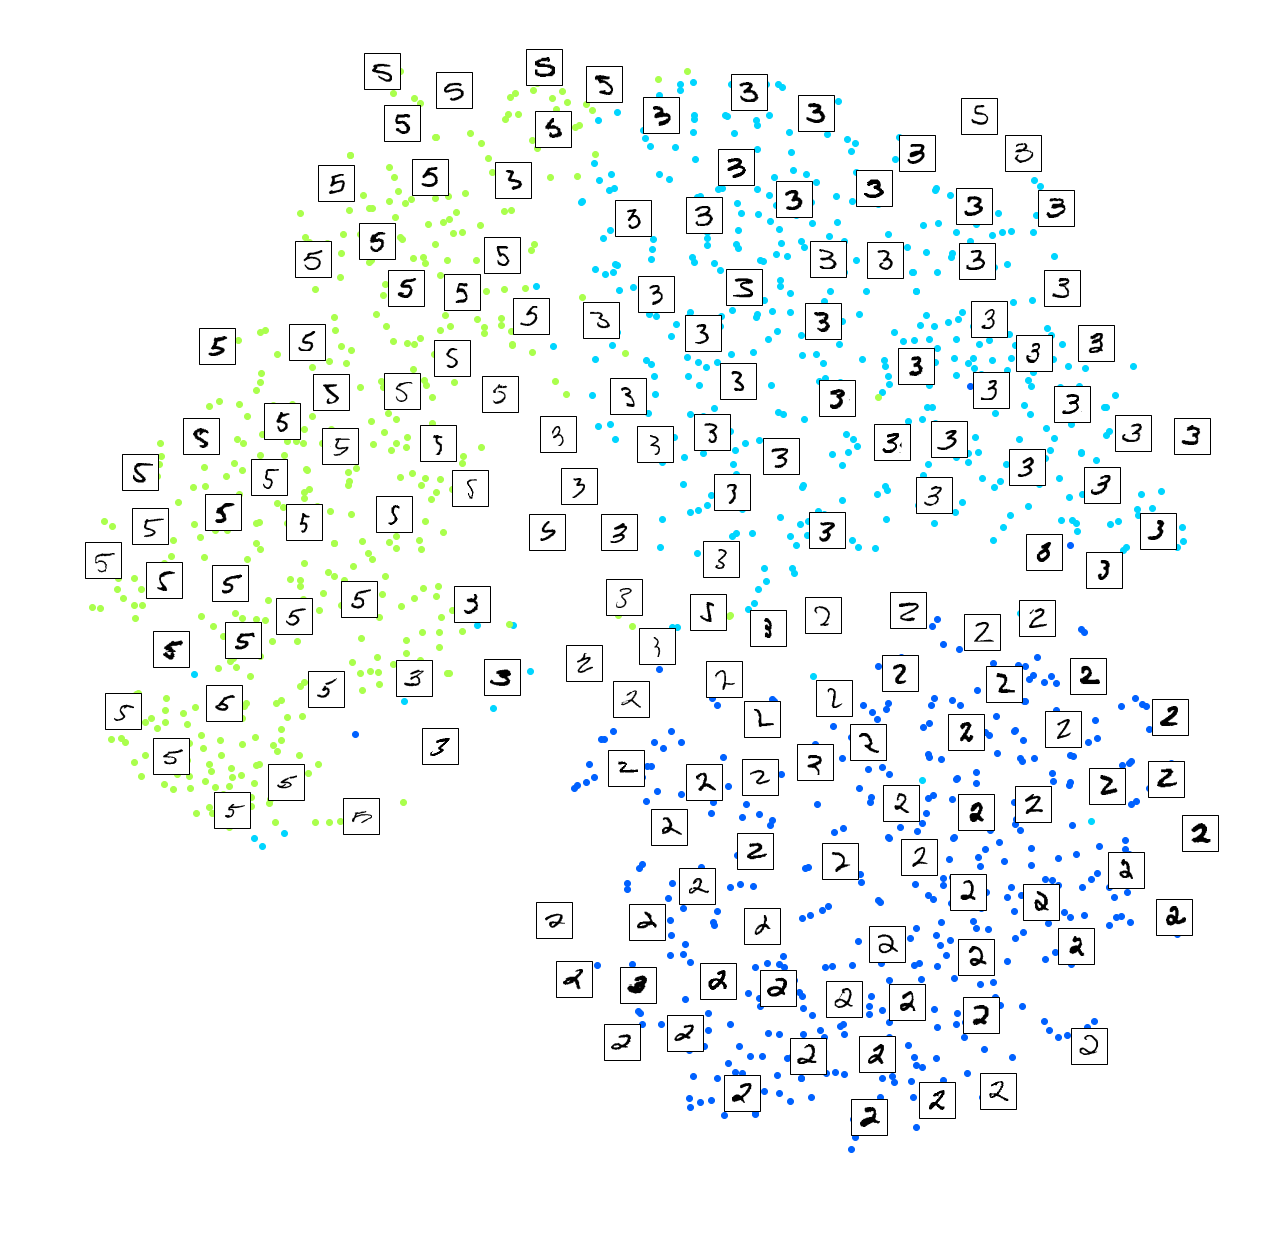

In [43]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

PCA took 3.2s.


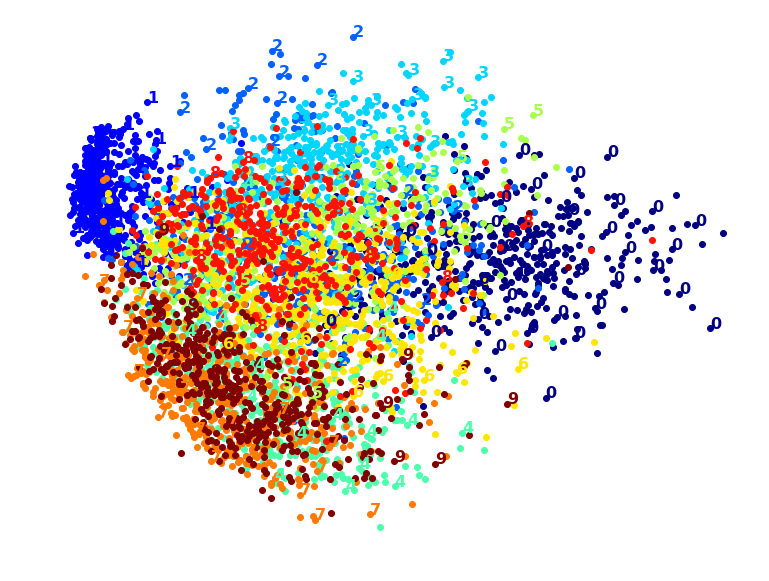

In [44]:
from sklearn.decomposition import PCA
import time

t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("PCA took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_reduced, y)
plt.show()